In [2]:
import numpy as np
import math
import time
import pandas as pd
# from helper_functions import cross_validate
from sklearn import linear_model, ensemble
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn import linear_model
df = pd.read_csv('../data/elo_data.csv')


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import log_loss
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
# 假设 val_df 和 test_df 已经包含了所有必要的数据
# 计算 lead_margin 并添加到 DataFrame 中
df['set_victor'] = df['set_victor'].replace(0, method='bfill')
df['lead_margin'] = (df['p1_games'] - df['p2_games']) + (df['p1_points_won'] - df['p2_points_won']) / 6.0

scores = ['p1_games','p2_games','p1_score','p2_score']
break_feats = ['p1_break_pt', 'p2_break_pt']
point_rates = ['p1_ace', 'p2_ace']
baseline = ['lead_margin','sf_elo_diff_538']
cols = ['lead_margin','sf_elo_diff_538'] + scores + break_feats + point_rates

baseline = ['lead_margin','elo_diff','s_elo_diff']
column_lists = [baseline,scores,baseline+scores,cols]


test_match_id = '2023-wimbledon-1301'  # 选择您想用作测试集的match_id
models = [linear_model.LogisticRegression(fit_intercept=True,max_iter=1000)]
model_hparams = {'LogisticRegression': {'C': [100]}}

# 根据选定的match_id将数据分为训练集和测试集
# train_data = df[df['match_id'] != test_match_id]  # 选择除了测试集之外的数据作为训练集
# test_data = df[df['match_id'] == test_match_id]   # 选择测试集数据
# 定义特征列和目标变量
column_lists = ['lead_margin', 'sf_elo_diff_538', 'p1_break_pt', 'p2_break_pt']
# # 划分训练集
# Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, test_size=0.1)
for clf in models:
    model_name = clf.__class__.__name__
    # print(clf,model_name)
    x = df[column_lists]
    y = df["set_victor"]
    
    # 使用 GridSearchCV 进行交叉验证和超参数调优
    param_grid = model_hparams[model_name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x, y)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    predictions = pd.DataFrame(data=np.zeros(x.shape[0]), columns=["In Match Predictions"])
    best_clf = grid_search.best_estimator_
    

    for train_index,test_index in kfold.split(x, y):
        model = clone(best_clf)
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = x.iloc[test_index]
        y_test = y.iloc[test_index]
    
        model.fit(x_train, y_train)
        prediction = model.predict_proba(x_test)[:, 0]
        pred = pd.DataFrame(prediction, index=test_index, columns=["In Match Predictions"])
    
        predictions["In Match Predictions"][test_index] = pred["In Match Predictions"]


        # 预测和评估
        probs_train = best_clf.predict_proba(x)
        probs_test = best_clf.predict_proba(y_test)
        train_loss = log_loss(y_train, probs_train, labels=best_clf.classes_)
        test_loss = log_loss(y_test, probs_test, labels=best_clf.classes_)
        train_accuracy = best_clf.score(x, y)
        test_accuracy = best_clf.score(x_test, y_test)
    
        print('Train Loss:', train_loss, 'Test Loss:', test_loss)
        print('Train Accuracy:', train_accuracy, 'Test Accuracy:', test_accuracy)
    
    print(predictions)


C:\Users\Gingko\Desktop\Projects\Modeling2024\.venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

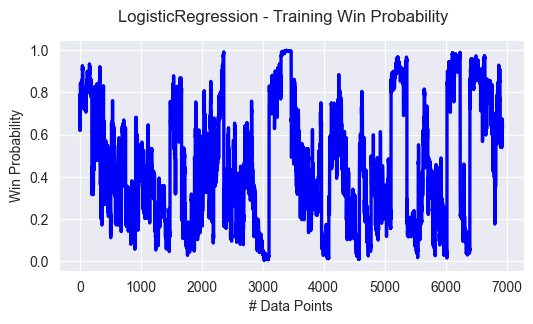

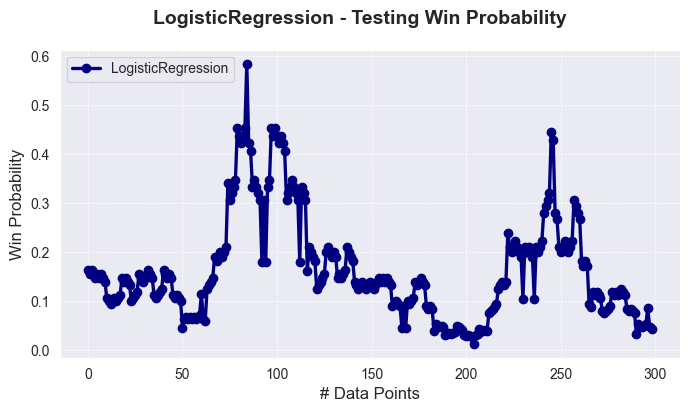

In [14]:
train_probabilities = {}
test_probabilities = {}
train_probabilities[model_name] = probs_train[:, 1]  # 取第一列的概率值
test_probabilities[model_name] = probs_test[:, 1]    # 取第一列的概率值
for model_name, train_prob in train_probabilities.items():
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(len(train_prob)), train_prob, 'b-', linewidth=2.4)
    fig.suptitle(f'{model_name} - Training Win Probability')
    ax.set_ylabel('Win Probability')
    ax.set_xlabel('# Data Points')
    plt.show()


for model_name, test_prob in test_probabilities.items():
    fig = plt.figure(figsize=(8, 4))  # 调整图表大小
    ax = fig.add_subplot(1, 1, 1)
    
    # 使用更引人注目的颜色和线型，添加数据点标记
    ax.plot(np.arange(len(test_prob)), test_prob, 'o-', color='navy', linewidth=2.4, markersize=6)
    
    # 增加格子线以提高可读性
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 设置标题和轴标签，调整字体大小和样式
    fig.suptitle(f'{model_name} - Testing Win Probability', fontsize=14, fontweight='bold')
    ax.set_ylabel('Win Probability', fontsize=12)
    ax.set_xlabel('# Data Points', fontsize=12)
    
    # 添加图例
    ax.legend([model_name], loc='upper left')

    plt.show()
    


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# 假设 val_df 和 test_df 已经包含了所有必要的数据
# 计算 lead_margin 并添加到 DataFrame 中
df['set_victor'] = df['set_victor'].replace(0, method='bfill')
df['lead_margin'] = (df['p1_games'] - df['p2_games']) + (df['p1_points_won'] - df['p2_points_won']) / 6.0

scores = ['p1_games','p2_games','p1_score','p2_score']
break_feats = ['p1_break_pt', 'p2_break_pt']
point_rates = ['p1_ace', 'p2_ace']
baseline = ['lead_margin','sf_elo_diff_538']
cols = ['lead_margin','sf_elo_diff_538'] + scores + break_feats + point_rates

baseline = ['lead_margin','elo_diff','s_elo_diff']
column_lists = [baseline,scores,baseline+scores,cols]


test_match_id = '2023-wimbledon-1301'  # 选择您想用作测试集的match_id
models = [linear_model.LogisticRegression(fit_intercept=True,max_iter=1000)]
model_hparams = {'LogisticRegression': {'C': [100]}}

# 根据选定的match_id将数据分为训练集和测试集
train_data = df[df['match_id'] != test_match_id]  # 选择除了测试集之外的数据作为训练集
test_data = df[df['match_id'] == test_match_id]   # 选择测试集数据
print(test_data.shape)
# 定义特征列和目标变量
column_lists = ['lead_margin', 'sf_elo_diff_538', 'p1_break_pt', 'p2_break_pt']
Xtrain = train_data[column_lists]
Ytrain = train_data['set_victor']
Xtest = test_data[column_lists]
ytest = test_data['set_victor']
# # 划分训练集
# Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, test_size=0.1)
for clf in models:
    model_name = clf.__class__.__name__
    # print(clf,model_name)

    # 使用 GridSearchCV 进行交叉验证和超参数调优
    param_grid = model_hparams[model_name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(Xtrain, Ytrain)

    # 使用最优参数重新训练模型
    best_clf = grid_search.best_estimator_
    best_clf.fit(Xtrain, Ytrain)

    # 预测和评估
    probs_train = best_clf.predict_proba(Xtrain)
    probs_test = best_clf.predict_proba(Xtest)
    train_loss = log_loss(Ytrain, probs_train, labels=best_clf.classes_)
    test_loss = log_loss(ytest, probs_test, labels=best_clf.classes_)
    train_accuracy = best_clf.score(Xtrain, Ytrain)
    test_accuracy = best_clf.score(Xtest, ytest)

    print('Train Loss:', train_loss, 'Test Loss:', test_loss)
    print('Train Accuracy:', train_accuracy, 'Test Accuracy:', test_accuracy)
print('\n')

(299, 60)
Train Loss: 0.5049247202477819 Test Loss: 0.5465342048415966
Train Accuracy: 0.7255807242822103 Test Accuracy: 0.6956521739130435
